# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore
from vanna.utils import snake_case

In [2]:
model_name = 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [4]:
vn = MyVanna(config=CONFIG)

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [6]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [7]:
vn.run_sql_is_set

True

In [8]:
if clean_and_train:
    vn.remove_collection()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [9]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [10]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [11]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)




Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)


Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO

In [12]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl
9,4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl,default,None,"CREATE INDEX IFK_TrackAlbumId ON ""tracks"" (Alb...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if df['NumberOfCustomers'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=df['NumberOfCustomers'],
        y=[''] * len(df),
        orientation='h'
    ))

fig.update_layout(title="Number of Customers")

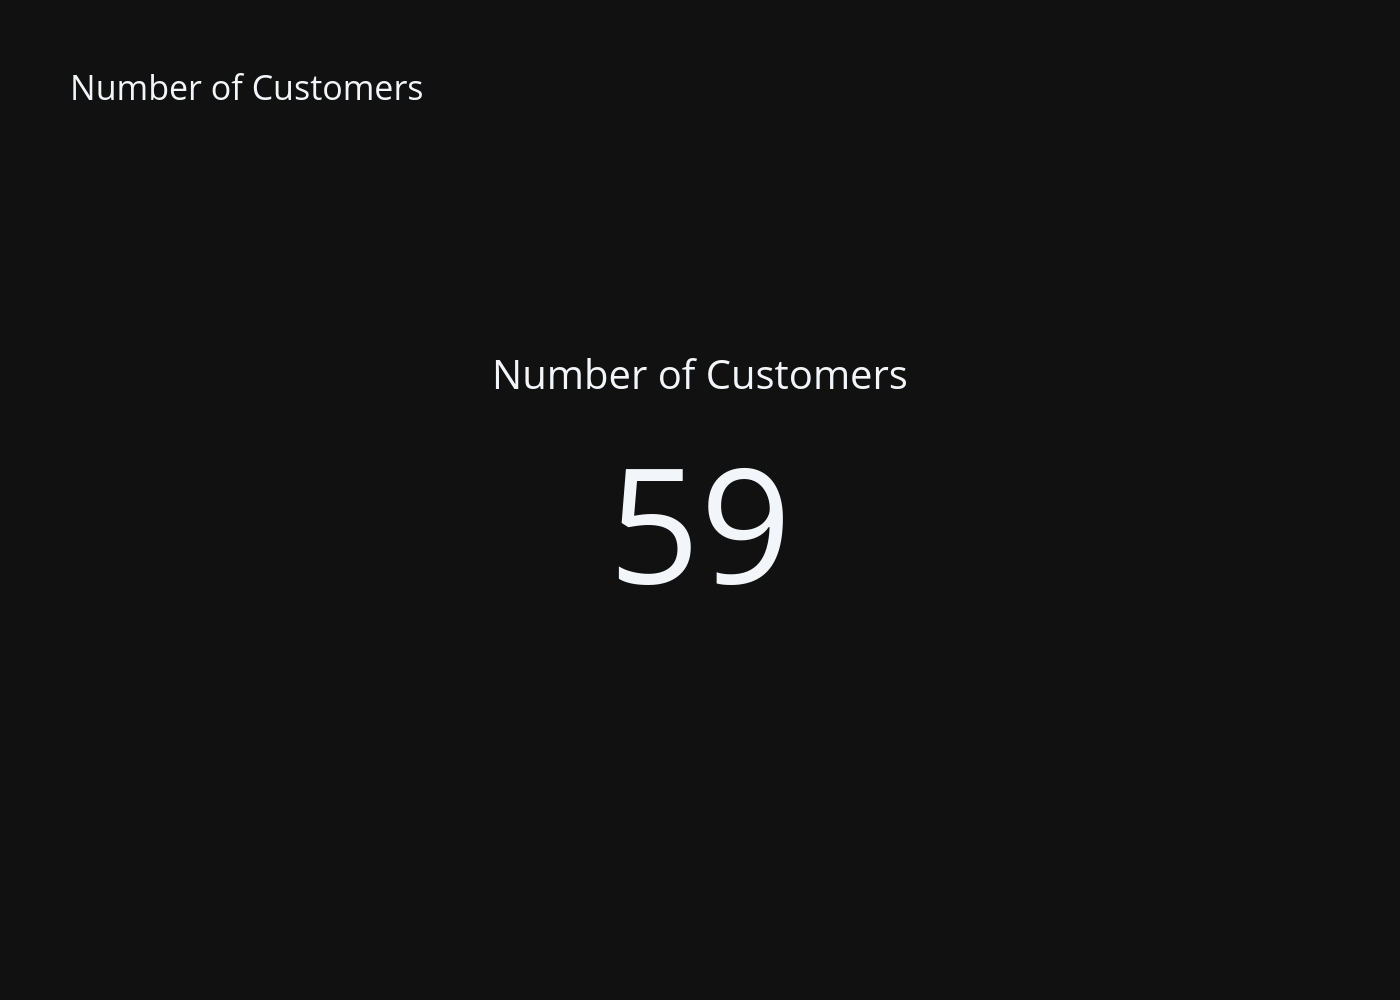

elapsed_time = 6.636954069137573


In [13]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [14]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

df = df.head(20) if len(df) > 20 else df

if df.empty:
    fig = go.Figure(go.Indicator(mode="number", value=1, title={"text": "No Tables"}))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), cells=dict(values=[[str(i) for i in df[col]] for col in df.columns]))])

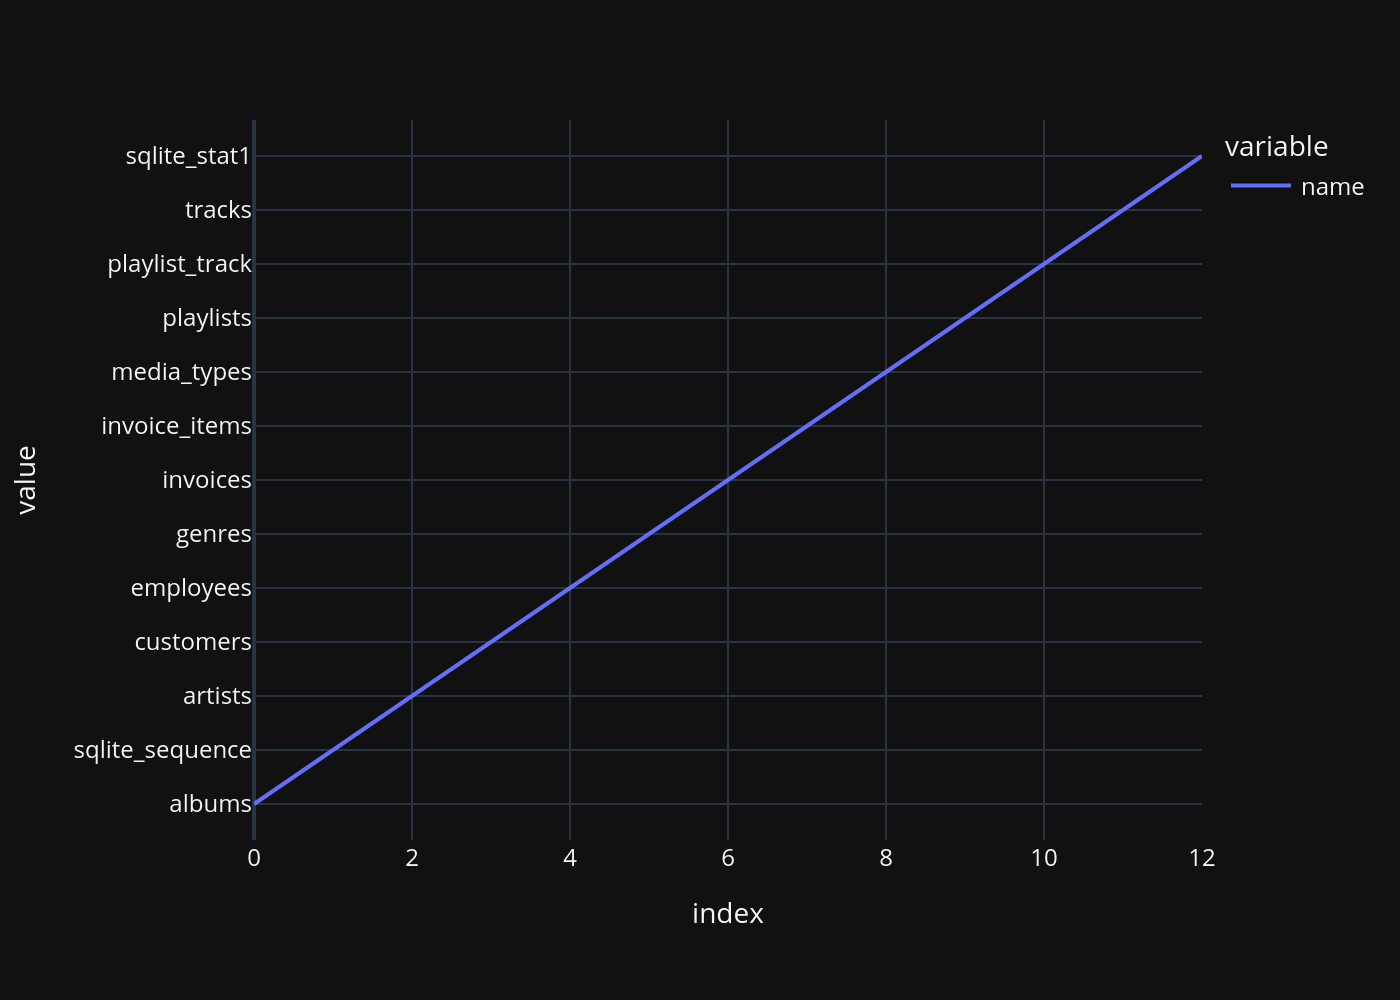





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT i.*
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
WHERE c.FirstName = 'John' AND c.LastName = 'Doe';


[( <SQL> )]
generated SQL statement



SELECT i.*
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
WHERE c.FirstName = 'John' AND c.LastName = 'Doe';


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total



[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%order%' OR name LIKE '%orders%';


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table' AND (name LIKE '%order%' OR name LIKE '%orders%') limit 20;


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table' AND (name LIKE '%order%' OR name LIKE '%orders%') limit 20;


[( <DataFrame> )]
queried dataframe



,name



[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT * FROM invoices limit 20;


[( <SQL> )]
generated SQL statement



SELECT * FROM invoices limit 20;


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
5,6,37,2009-01-19 00:00:00,Berger Straße 10,Frankfurt,None,Germany,60316,0.99
6,7,38,2009-02-01 00:00:00,Barbarossastraße 19,Berlin,None,Germany,10779,1.98
7,8,40,2009-02-01 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
8,9,42,2009-02-02 00:00:00,"9, Place Louis Barthou",Bordeaux,None,France,33000,3.96
9,10,46,2009-02-03 00:00:00,3 Chatham Street,Dublin,Dublin,Ireland,None,5.94



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame
if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:
    fig = px.indicator(value=df['Total'].values[0], title='Total Invoice Amount')
else:
    fig = px.bar(df, x='InvoiceId', y='Total', text='Total', title='Invoice Totals')

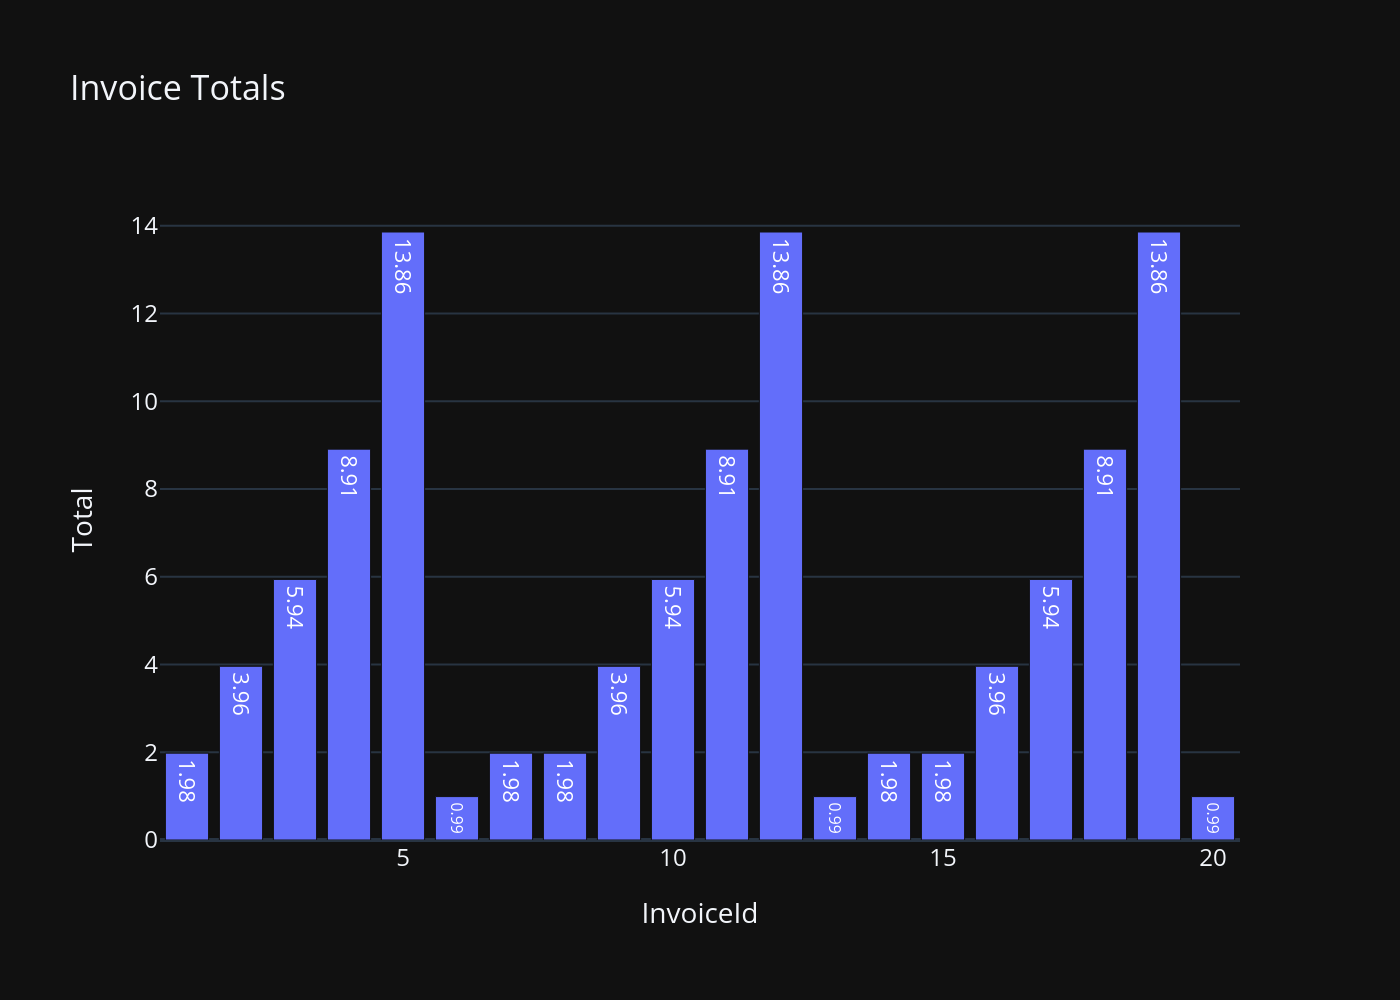


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame
if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:
    fig = px.indicator(value=df['name'].iloc[0], title='Single Value Indicator')
else:
    fig = px.bar(df, x='name', y=[0]*len(df), text_auto='.2s', title='Customer Orders Table Names')

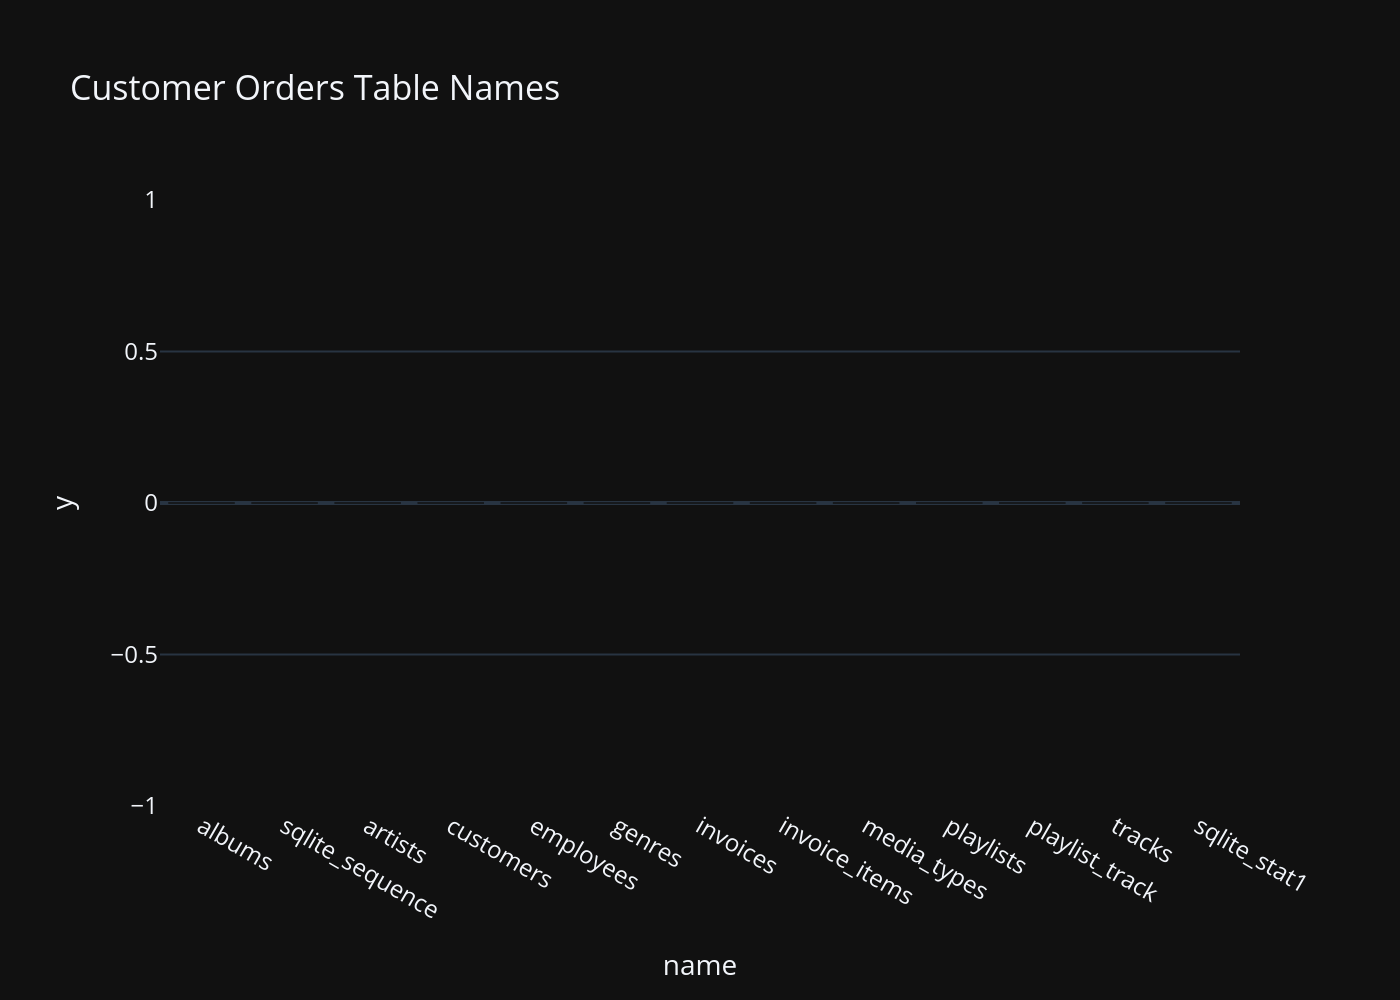





# QUESTION  - 4:  How many customers are there



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if df['NumberOfCustomers'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=df['NumberOfCustomers'],
        y=[''] * len(df),
        orientation='h'
    ))

fig.update_layout(title="Number of Customers")

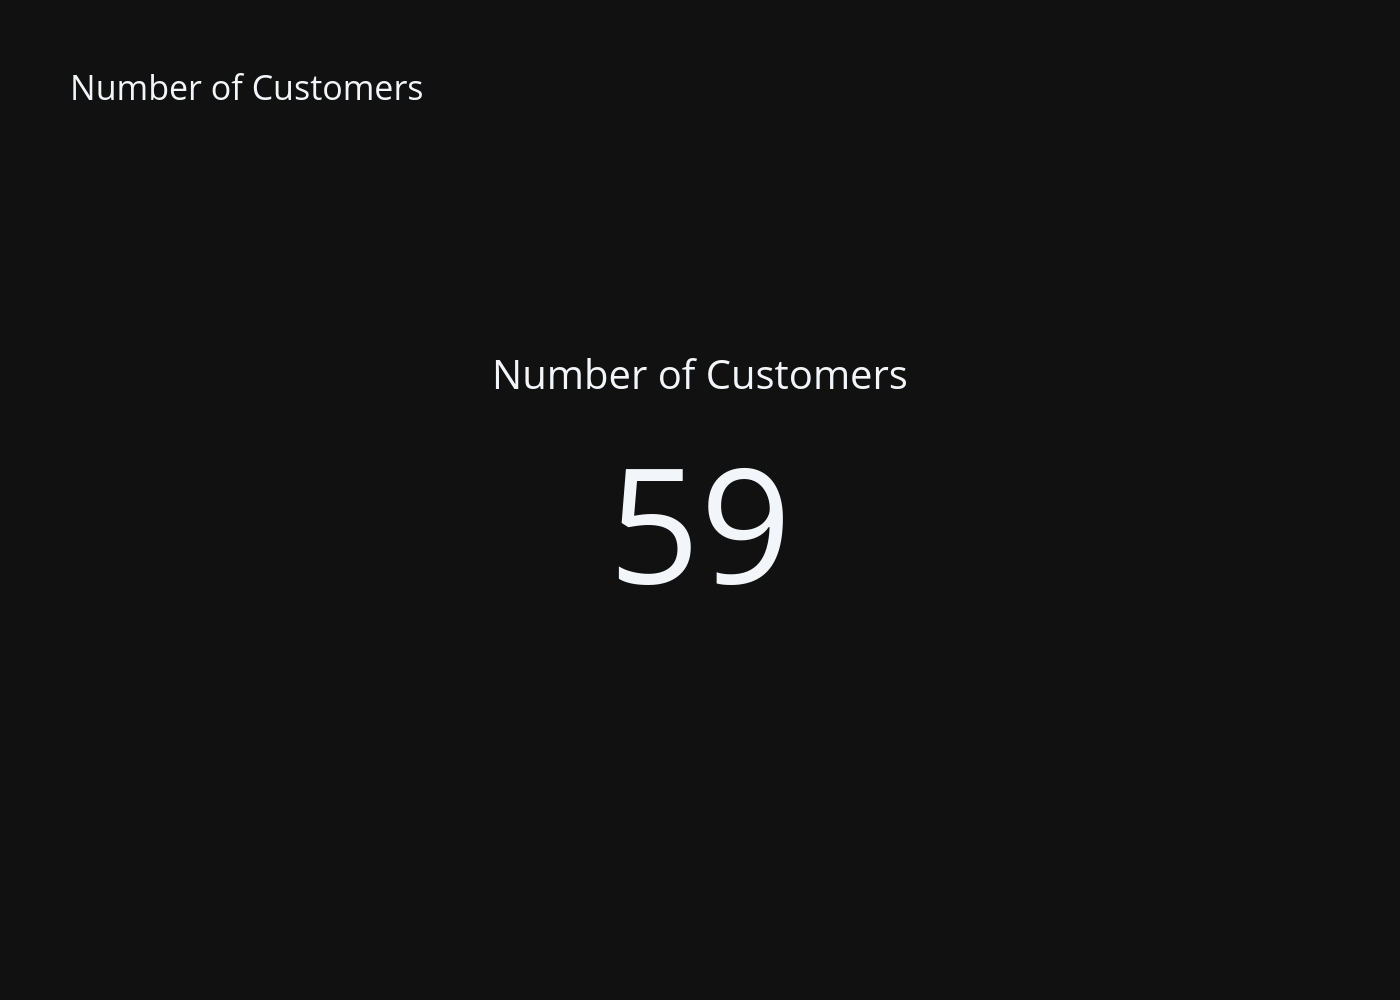





# QUESTION  - 5:  what are the top 5 countries that customers come from?



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS CustomerCount
FROM invoices
GROUP BY BillingCountry
ORDER BY CustomerCount DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS CustomerCount
FROM invoices
GROUP BY BillingCountry
ORDER BY CustomerCount DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,BillingCountry,CustomerCount
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df['BillingCountry'].unique()) == 1:
    fig = px.indicator(title="Single Country Indicator", value=len(df), label="Countries")
else:
    fig = px.bar(df, x='BillingCountry', y='CustomerCount', text='CustomerCount')
    fig.update_layout(title='Top 5 Countries by Customer Count', xaxis_title='Country', yaxis_title='Number of Customers')

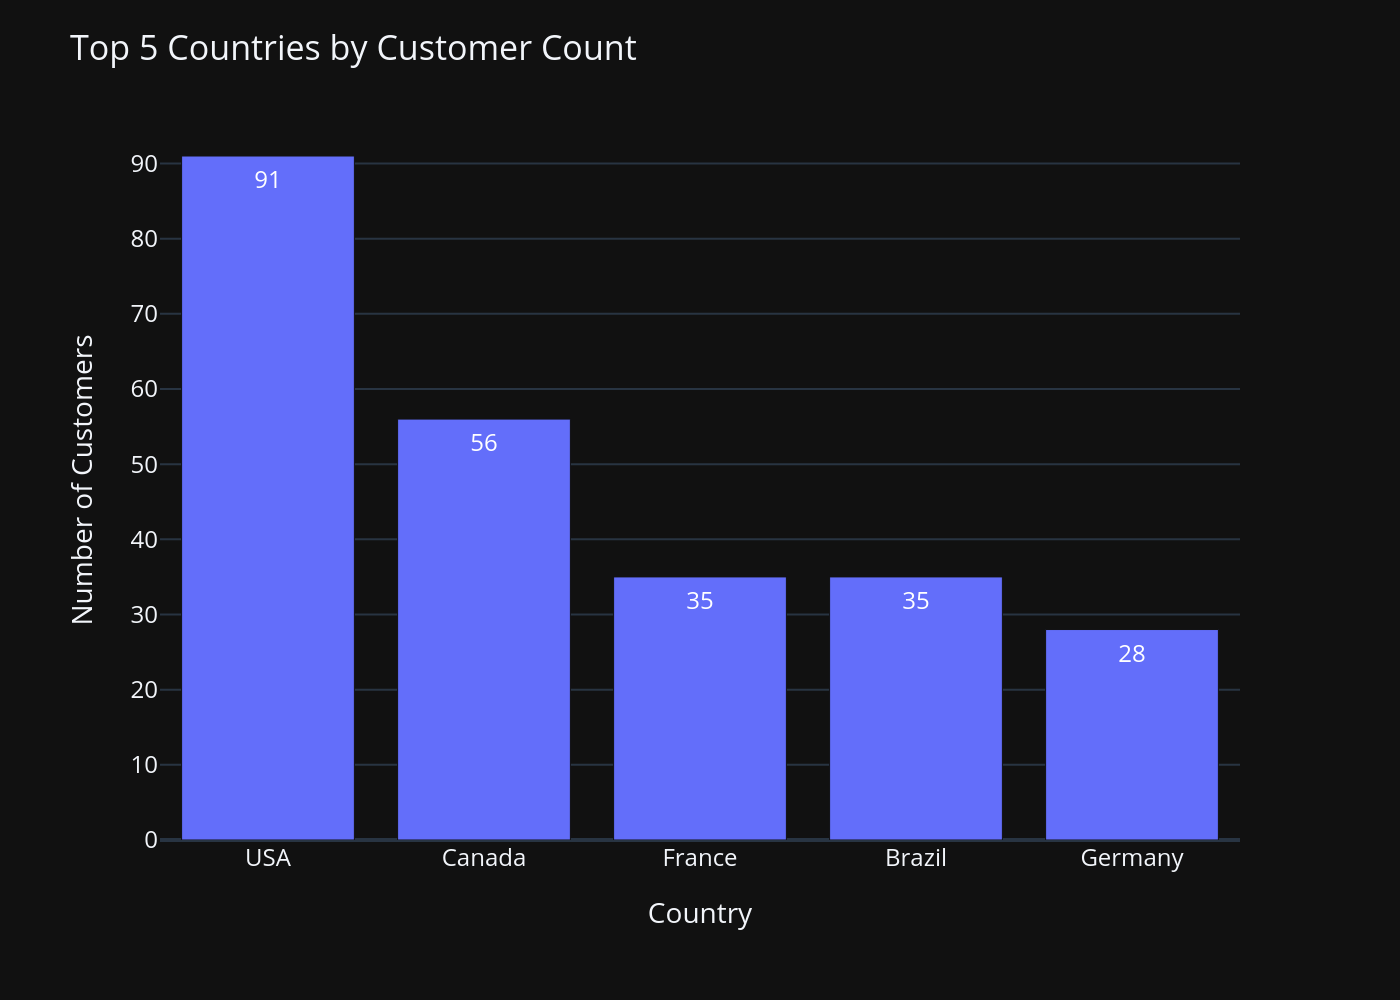





# QUESTION  - 6:  List all albums and their corresponding artist names  



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName
FROM albums
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <DataFrame> )]
queried dataframe



,AlbumTitle,ArtistName
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame
if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:
    fig = px.indicator(value=1, title="Single Value Indicator")
else:
    fig = px.bar(df, x='AlbumTitle', y='ArtistName', text='ArtistName')
    fig.update_layout(title='Albums and Artist Names', xaxis_title='Album Title', yaxis_title='Artist Name')

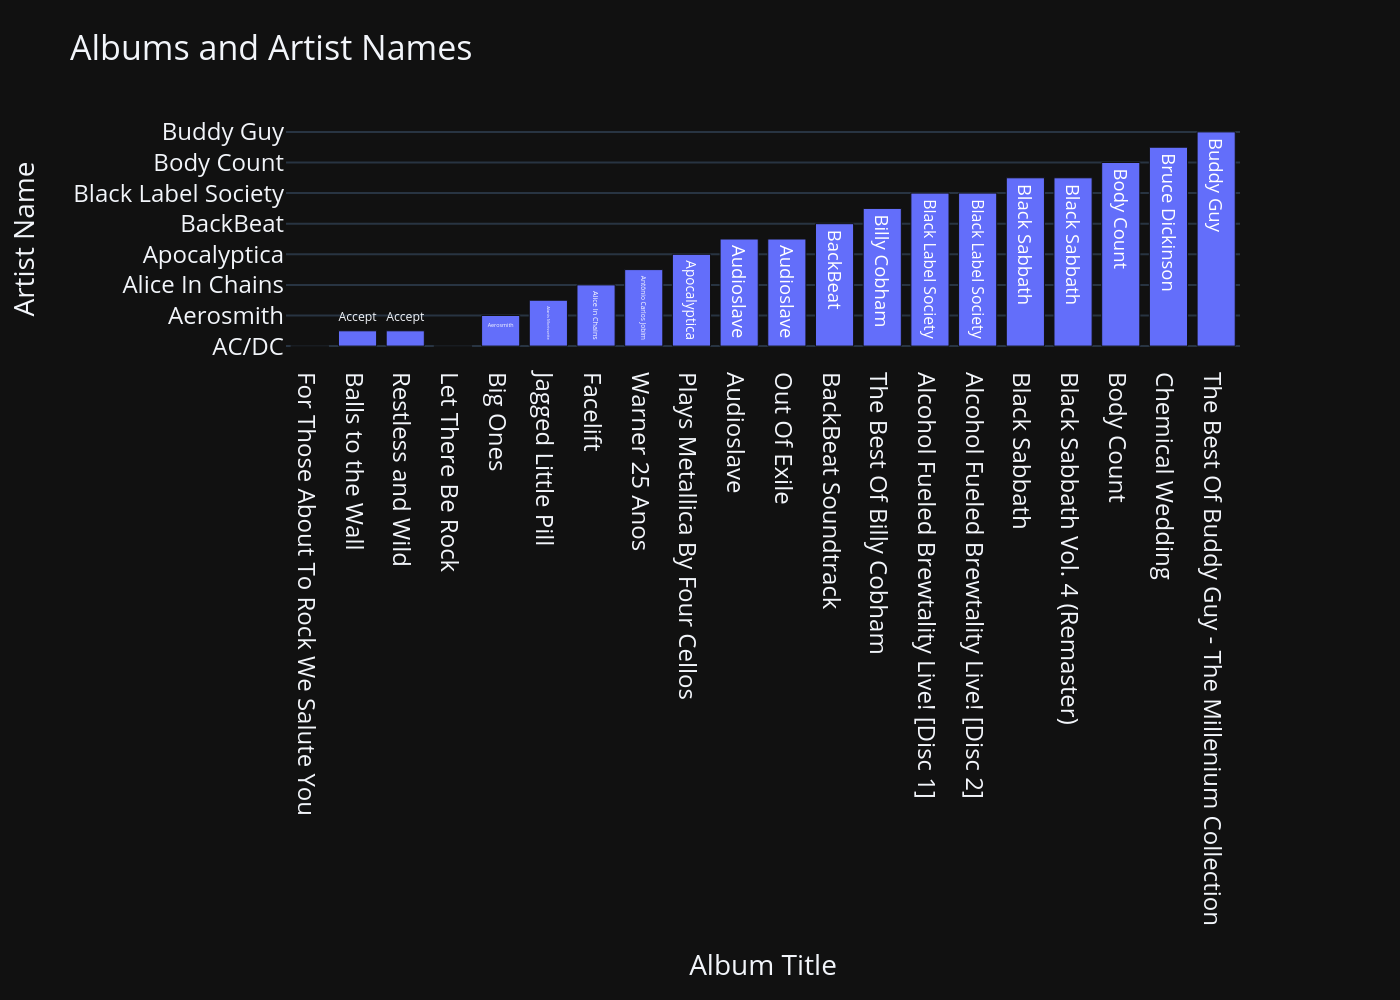





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT * FROM tracks
WHERE LOWER(Name) LIKE '%what%';


[( <SQL> )]
generated SQL statement



SELECT * FROM tracks
WHERE LOWER(Name) LIKE '%what%';


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Assuming 'df' is your DataFrame
if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:
    fig = go.Figure(go.Indicator(value=df['UnitPrice'].iloc[0], title={"text": "Unit Price"}))
else:
    fig = go.Figure()

fig.add_trace(go.Scatter(x=df['Name'], y=df['UnitPrice'], mode='markers', name='Unit Price by Track Name'))

fig.update_layout(title='Track Unit Prices by Name', xaxis_title='Track Name', yaxis_title='Unit Price')

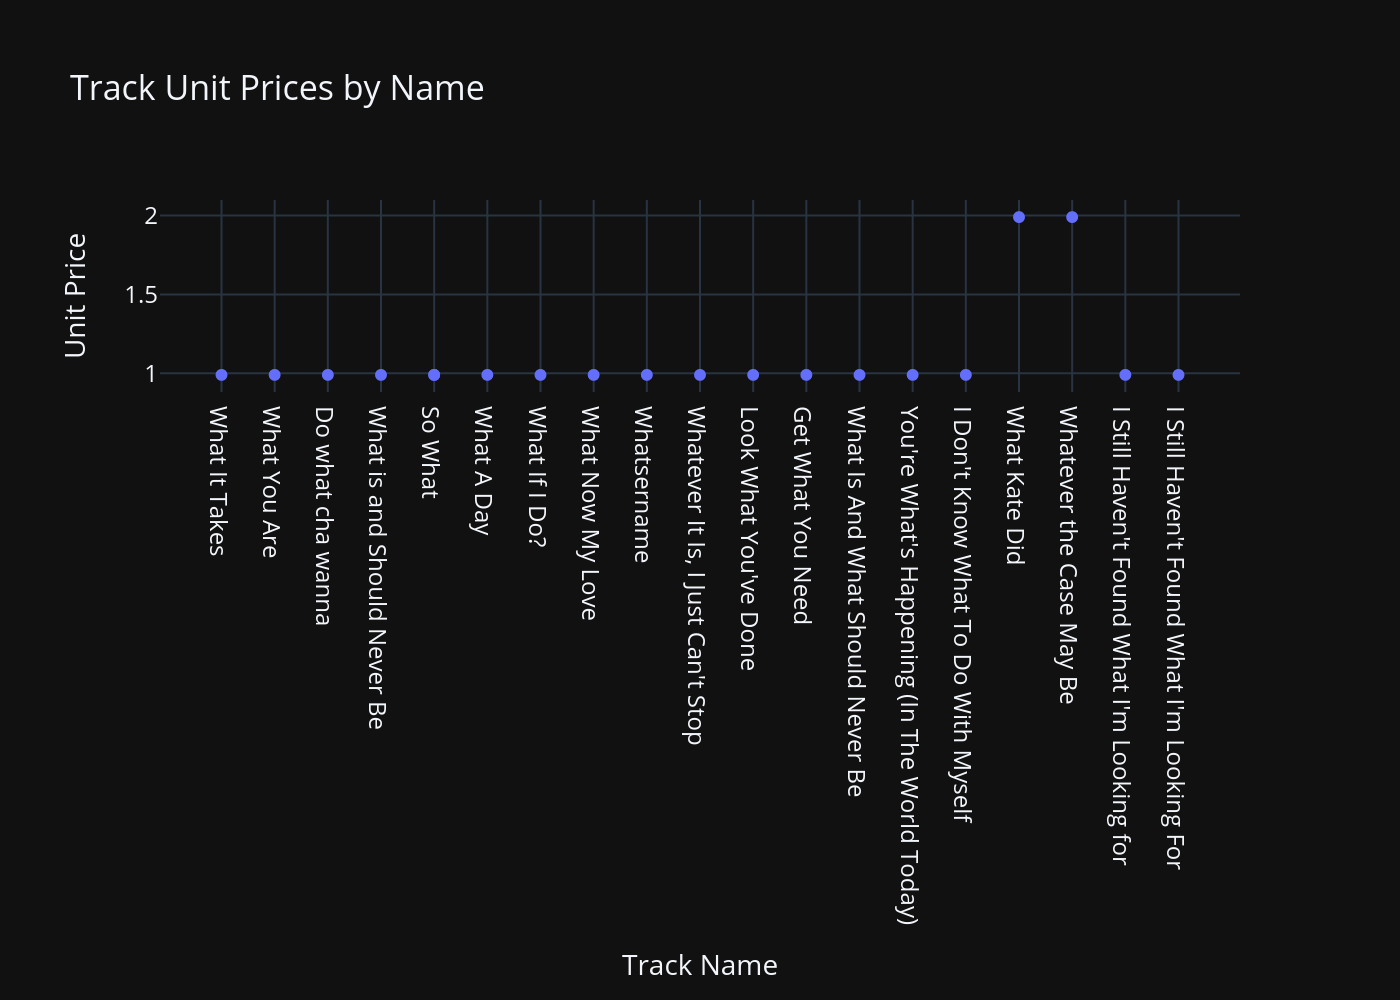





# QUESTION  - 8:  Get the total number of invoices for each customer



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Get the total number of invoices for each customer with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Get the total number of invoices for each customer with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu

SELECT BillingCountry, COUNT(*) AS TotalInvoices
FROM invoices
GROUP BY BillingCountry limit 20


[( <DataFrame> )]
queried dataframe



,BillingCountry,TotalInvoices
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df['TotalInvoices'].unique()) == 1:
    fig = px.indicator(value=df['TotalInvoices'].iloc[0], title="Total Invoices Per Country")
else:
    fig = px.bar(df, x='BillingCountry', y='TotalInvoices', text='TotalInvoices')
    fig.update_traces(texttemplate='%{text}', textposition='outside')

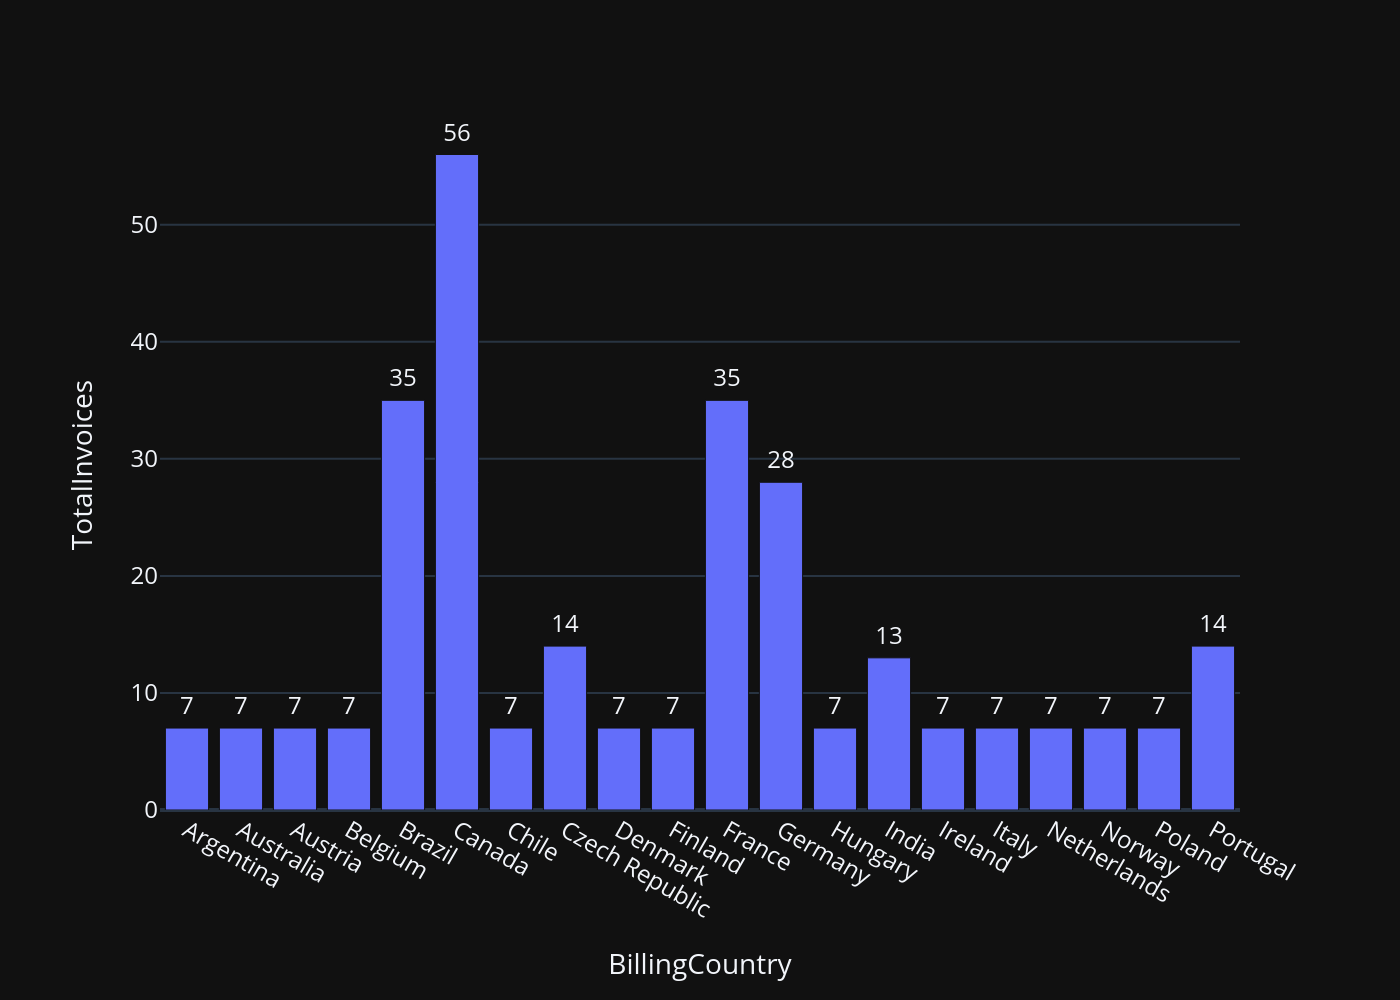





# QUESTION  - 10:  List all invoices with a total exceeding $10



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all invoices with a total exceeding $10 with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all invoices with a total exceeding $10 with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx

SELECT * FROM invoices WHERE Total > 10 limit 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

# Assuming 'df' is already defined and contains the data
if len(df) > 20:
    df = df.head(20)

fig = px.bar(df, x='InvoiceId', y='Total', text='Total')

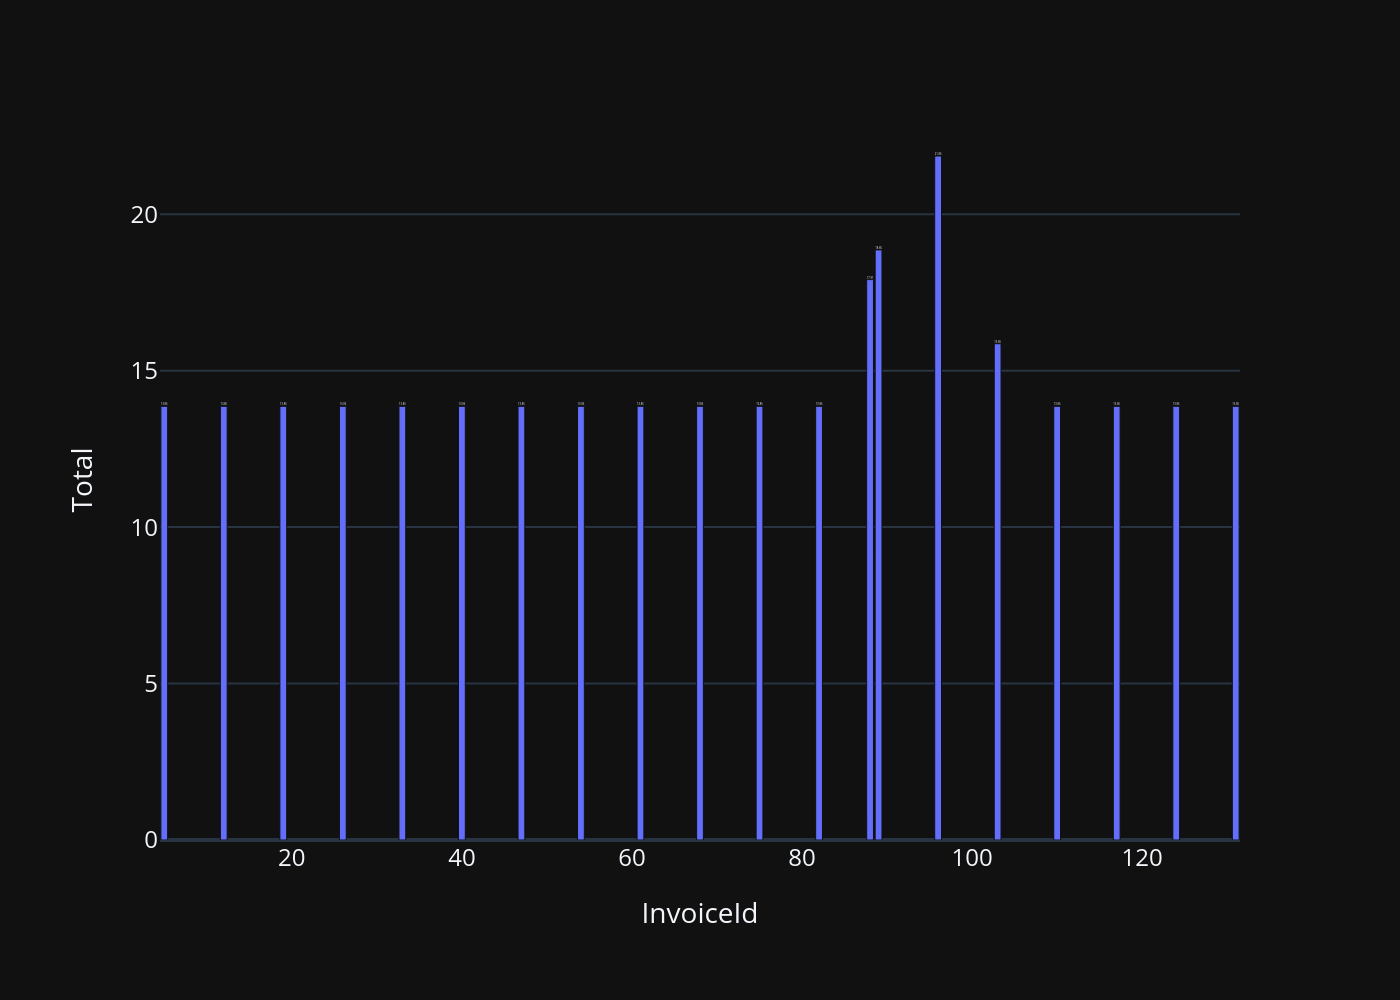





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find all invoices since 2010 and the total amount invoiced: with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find all invoices since 2010 and the total amount invoiced: with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-co

SELECT InvoiceId, SUM(Total) AS TotalAmountInvoiced
FROM invoices
WHERE InvoiceDate >= '2010-01-01'
GROUP BY InvoiceId limit 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,TotalAmountInvoiced
0,84,1.98
1,85,1.98
2,86,3.96
3,87,6.94
4,88,17.91
5,89,18.86
6,90,0.99
7,91,1.98
8,92,1.98
9,93,3.96



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df) == 1:
    fig = px.indicator(value=df['TotalAmountInvoiced'].values[0], title="Total Amount Invoiced")
else:
    fig = px.bar(df, x='InvoiceId', y='TotalAmountInvoiced', text='TotalAmountInvoiced')

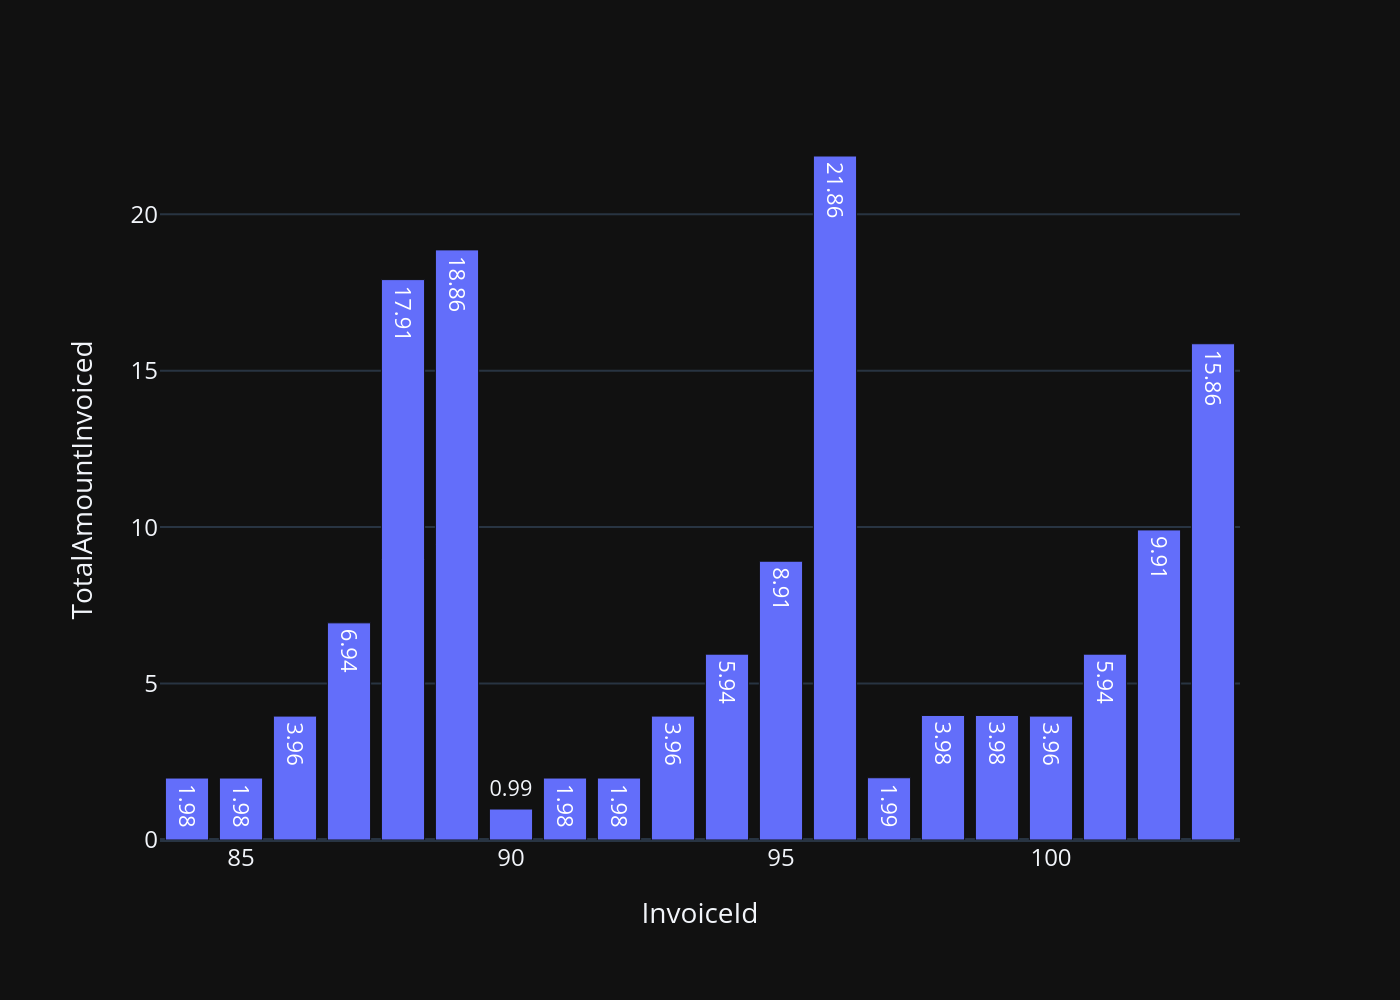





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all employees and their reporting manager's name (if any): with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: List all employees and their reporting manager's name (if any): with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model

SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, m.FirstName || ' ' || m.LastName AS ManagerName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId;


[( <DataFrame> )]
queried dataframe



,EmployeeName,ManagerName
0,Andrew Adams,None
1,Nancy Edwards,Andrew Adams
2,Jane Peacock,Nancy Edwards
3,Margaret Park,Nancy Edwards
4,Steve Johnson,Nancy Edwards
5,Michael Mitchell,Andrew Adams
6,Robert King,Michael Mitchell
7,Laura Callahan,Michael Mitchell



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

# Assuming 'df' is already defined and contains the data
if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:
    fig = px.indicator(value=1, title="Single Value Indicator")
else:
    fig = px.bar(df, x='EmployeeName', y='ManagerName', text_auto='.2s')
    fig.update_layout(title='Employees and Their Reporting Managers')

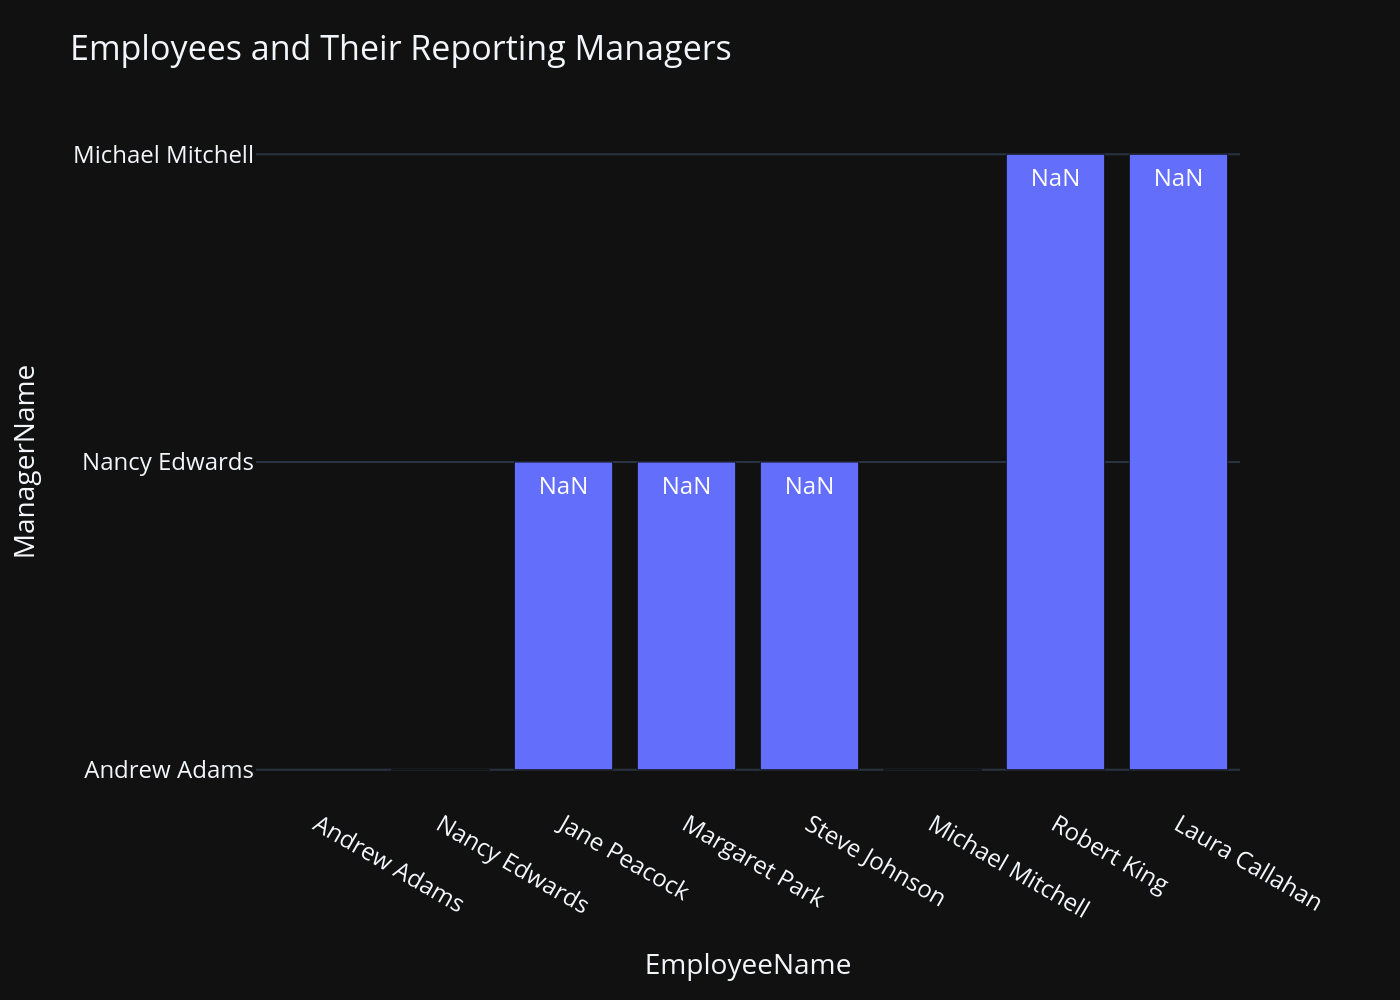





# QUESTION  - 13:   Get the average invoice total for each customer:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt:  Get the average invoice total for each customer: with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt:  Get the average invoice total for each customer: with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu':

SELECT c.FirstName, c.LastName, AVG(i.Total) AS AverageInvoiceTotal
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,AverageInvoiceTotal
0,Luís,Gonçalves,5.660000
1,Leonie,Köhler,5.374286
2,François,Tremblay,5.660000
3,Bjørn,Hansen,5.660000
4,František,Wichterlová,5.802857
5,Helena,Holý,7.088571
6,Astrid,Gruber,6.088571
7,Daan,Peeters,5.374286
8,Kara,Nielsen,5.374286
9,Eduardo,Martins,5.374286



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20)  # Limit to first 20 rows if more than 20 rows
if len(df) == 1:
    fig = px.indicator(value=df['AverageInvoiceTotal'].values[0], title="Average Invoice Total for Each Customer")
else:
    fig = px.bar(df, x='LastName', y='AverageInvoiceTotal', text='AverageInvoiceTotal', color='FirstName', title="Average Invoice Total for Each Customer")

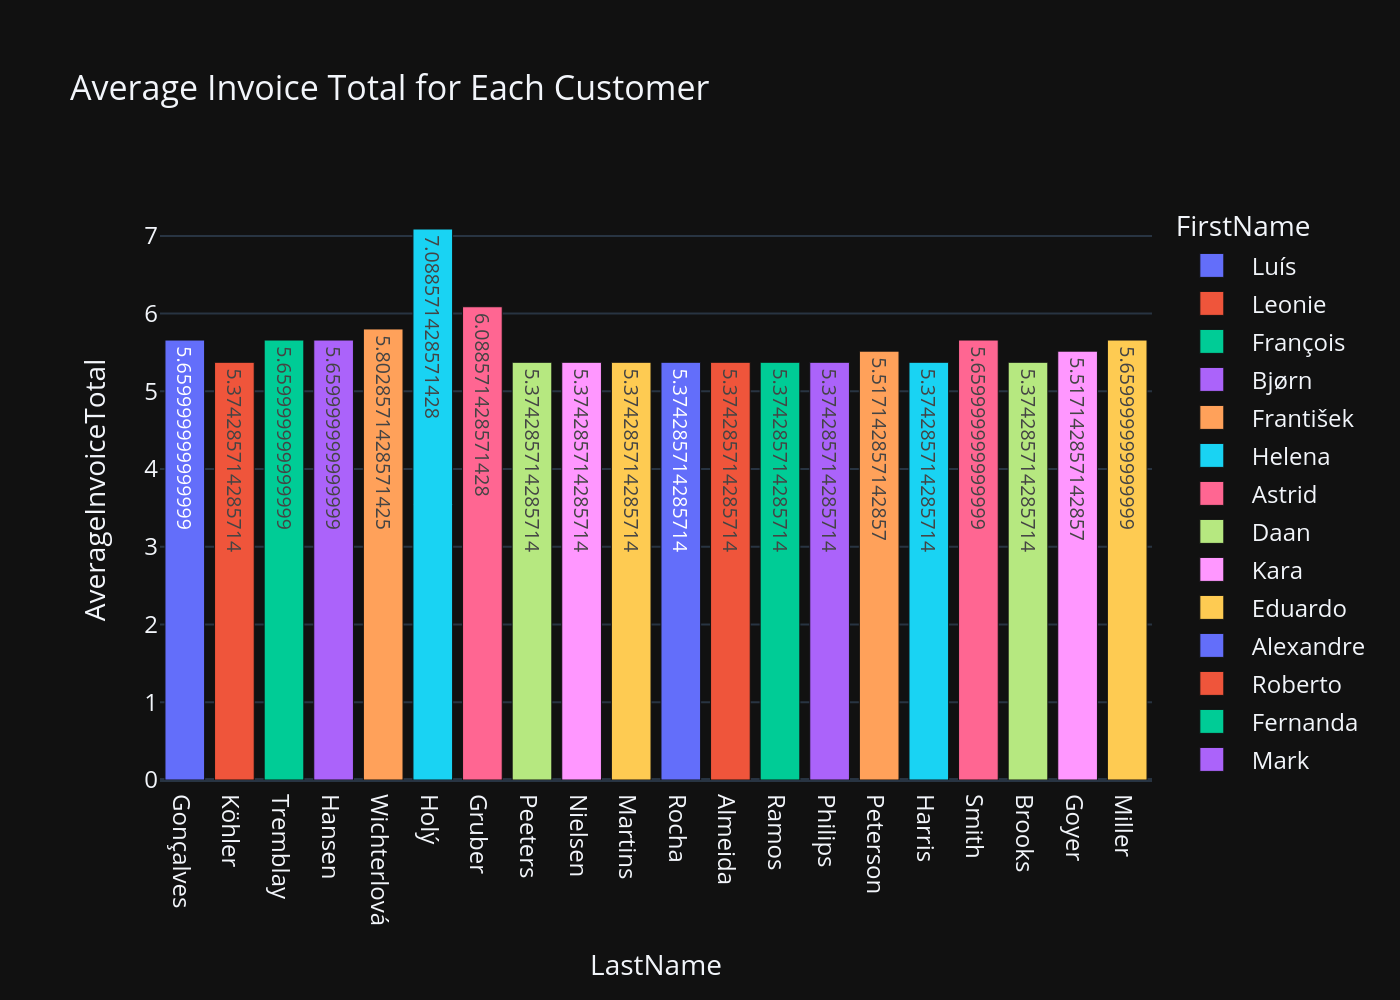





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT Name, UnitPrice
FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT Name, UnitPrice
FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Name,UnitPrice
0,Battlestar Galactica: The Story So Far,1.99
1,Occupation / Precipice,1.99
2,"Exodus, Pt. 1",1.99
3,"Exodus, Pt. 2",1.99
4,Collaborators,1.99



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df) == 1:
    fig = px.indicator(value=df['UnitPrice'].iloc[0], title="Top Most Expensive Track by Unit Price")
else:
    fig = px.bar(df, x='Name', y='UnitPrice', text='UnitPrice', color='UnitPrice', title="Top 5 Most Expensive Tracks by Unit Price", labels={'UnitPrice':'Unit Price'})

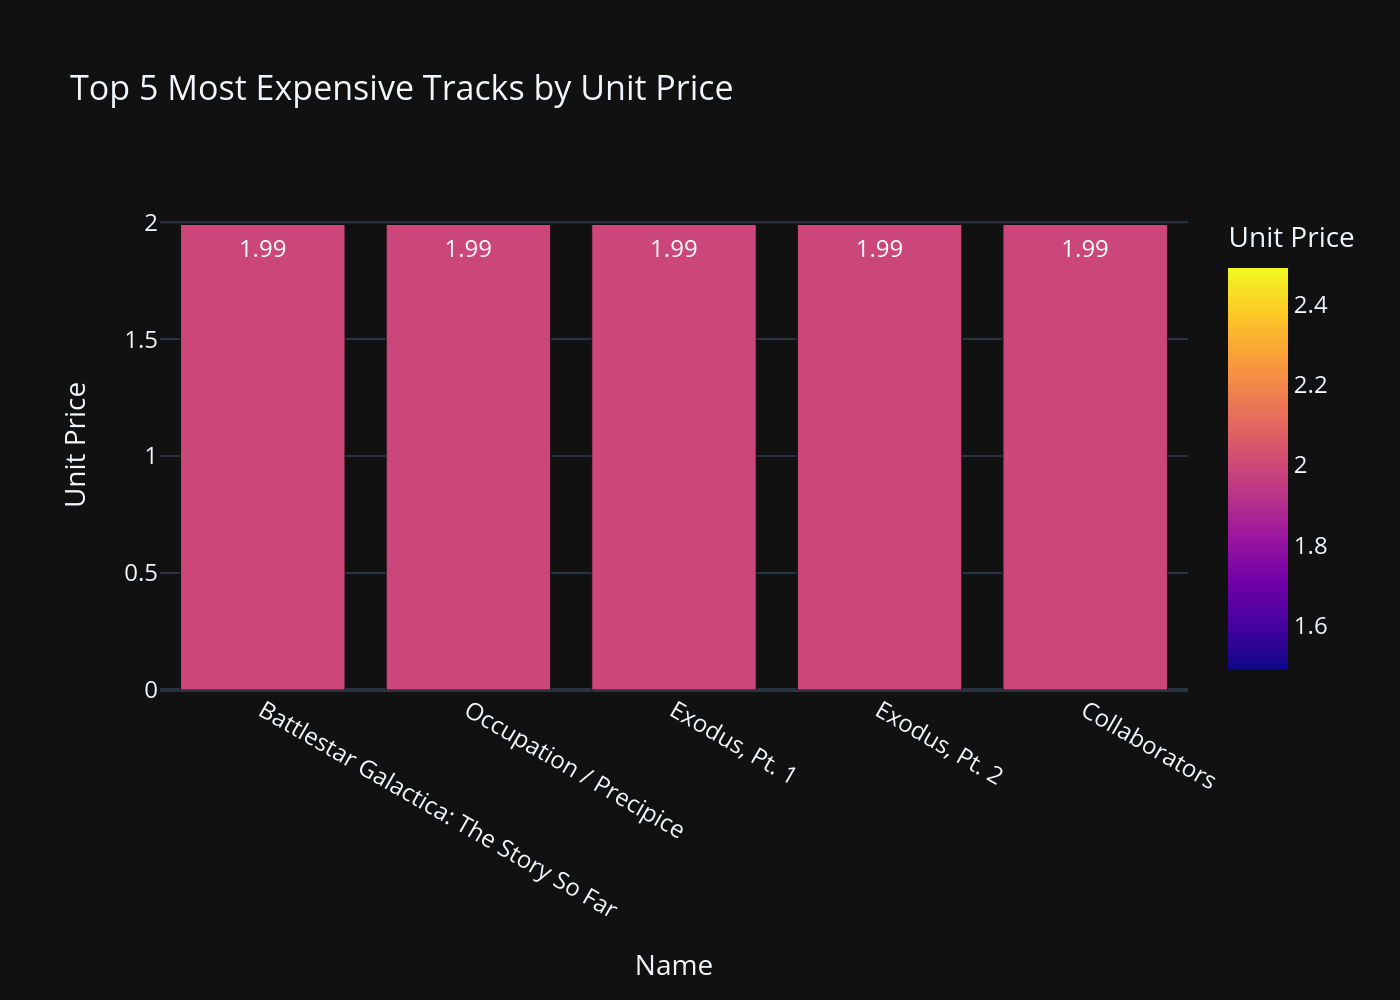





# QUESTION  - 15:  List all genres and the number of tracks in each genre:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.Name AS Genre, COUNT(t.TrackId) AS NumberOfTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId;


[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre, COUNT(t.TrackId) AS NumberOfTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId;


[( <DataFrame> )]
queried dataframe



,Genre,NumberOfTracks
0,Rock,1297
1,Jazz,130
2,Metal,374
3,Alternative & Punk,332
4,Rock And Roll,12
5,Blues,81
6,Latin,579
7,Reggae,58
8,Pop,48
9,Soundtrack,43



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20)  # Assuming df is defined and has more than 20 rows
if len(df) == 1:
    fig = px.indicator(value=df['NumberOfTracks'].iloc[0], title="Number of Tracks per Genre")
else:
    fig = px.bar(df, x='Genre', y='NumberOfTracks', text='NumberOfTracks')

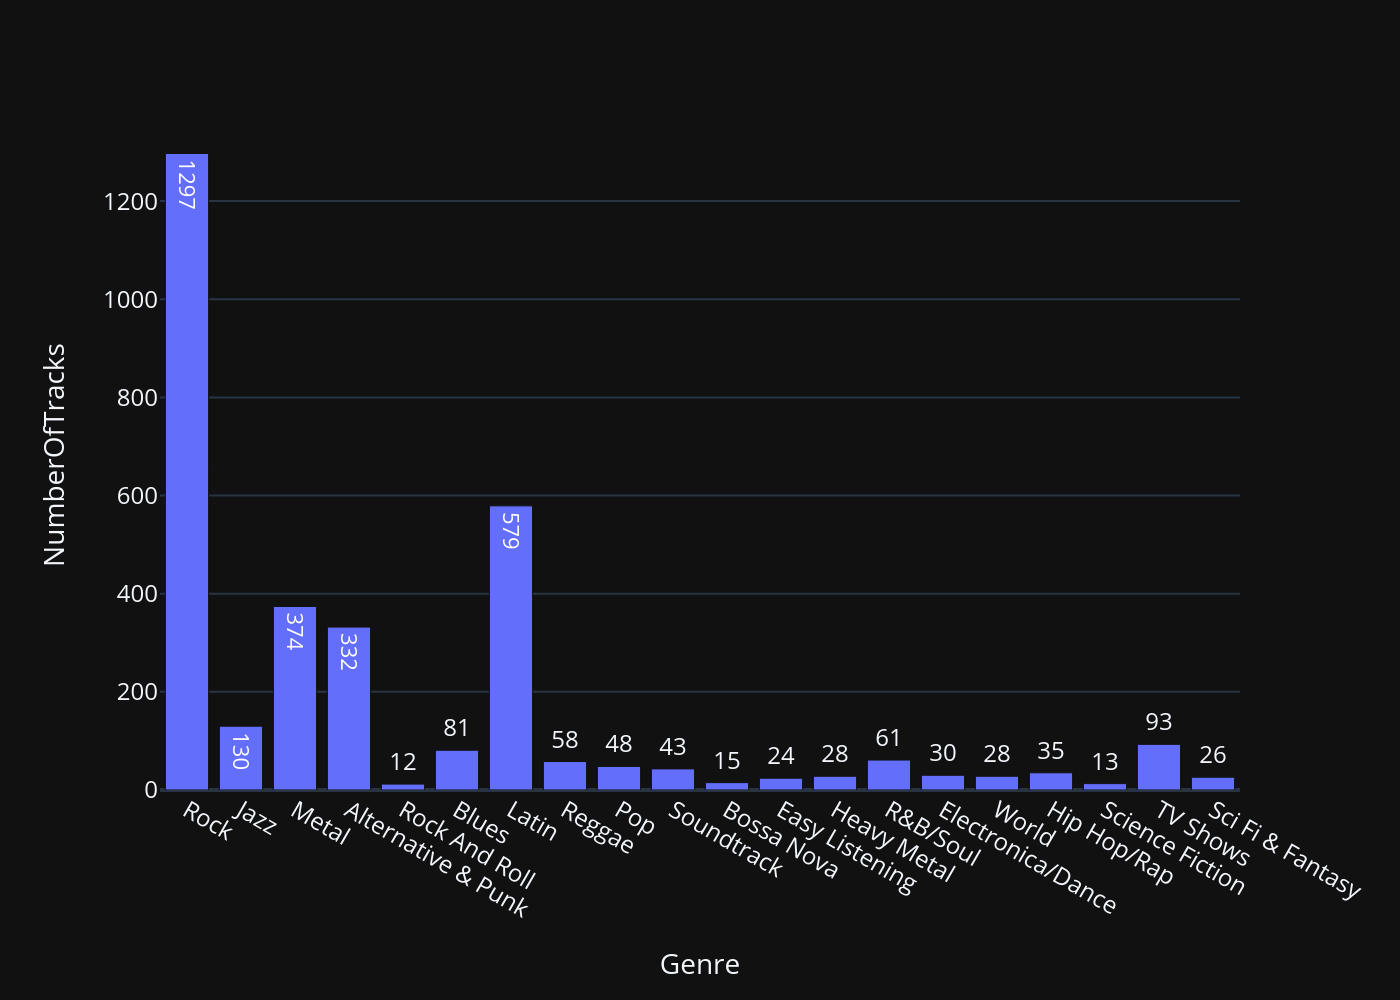





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.*
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT g.*
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,GenreId,Name



[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.GenreId, g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL;


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: 
                    Gene

SELECT c.FirstName, c.LastName
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName



[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: List all customers who have not placed any orders:
                    results in the following error: [ERROR-DF] Invalid dataframe .
                    Can you try to fix the error and re-generate the SQL statement?
                 with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: 
            

SELECT a.Name AS ArtistName, COUNT(t.TrackId) AS NumberOfTracks
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
GROUP BY a.ArtistId
ORDER BY NumberOfTracks DESC
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,ArtistName,NumberOfTracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df) == 1:
    fig = px.indicator(value=df['NumberOfTracks'].iloc[0], title="Top Artist by Number of Tracks")
else:
    fig = px.bar(df, x='ArtistName', y='NumberOfTracks', text='NumberOfTracks')
    fig.update_layout(title='Top 10 Most Popular Artists Based on Number of Tracks', xaxis_title='Artist Name', yaxis_title='Number of Tracks')

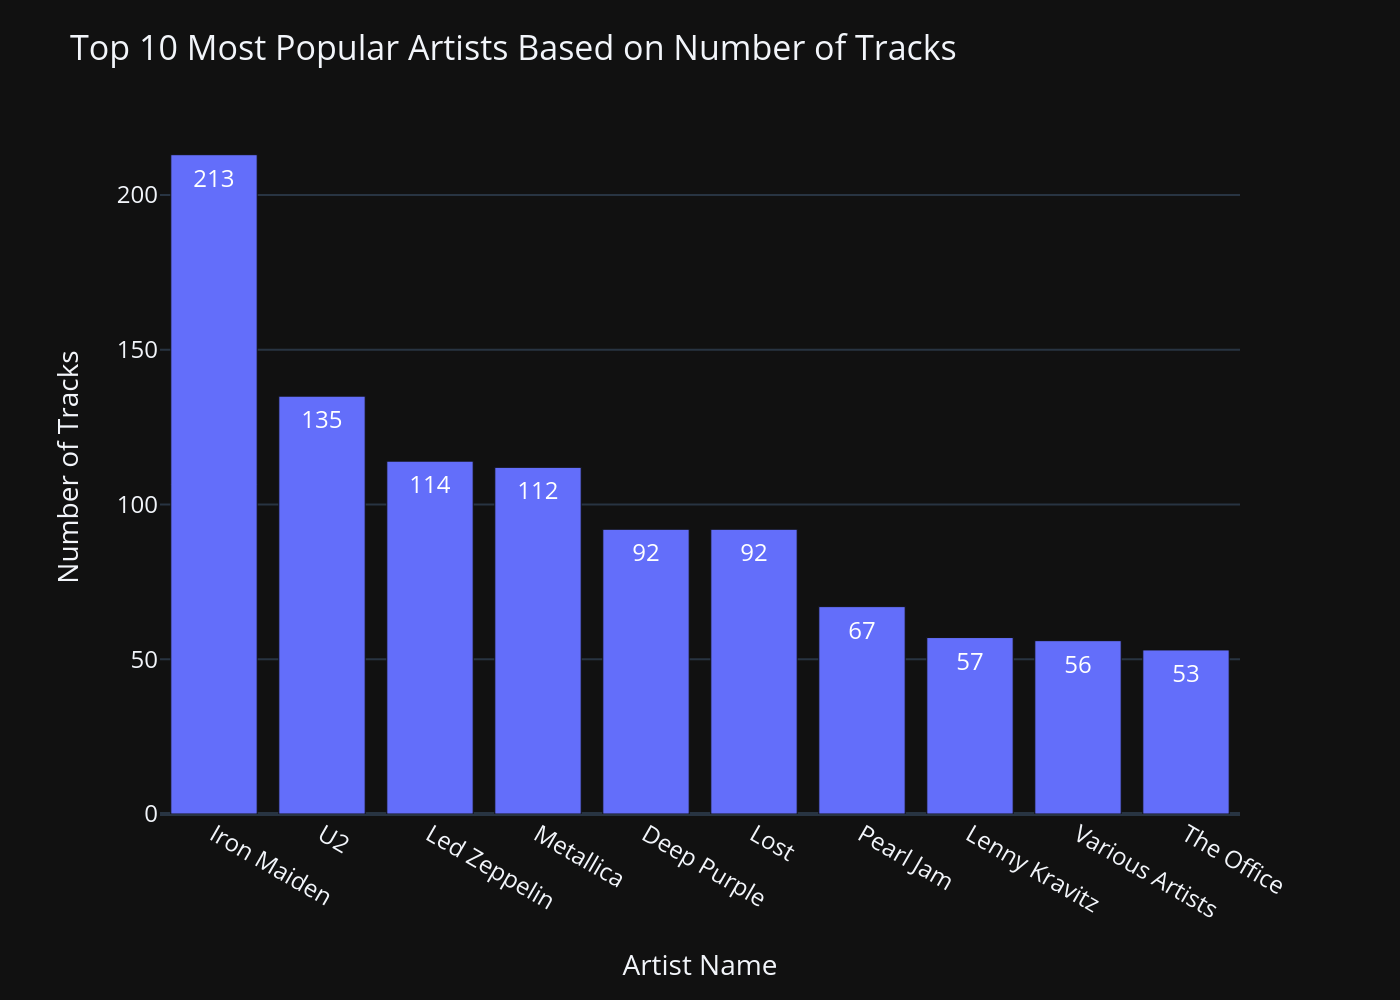





# QUESTION  - 19:  List all customers from Canada and their email addresses:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada';


[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada';


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20)  # Assuming df is your DataFrame and it has more than 20 rows
if df.empty:
    fig = px.indicator(title="No Data Available")
else:
    fig = px.bar(df, x='FirstName', y='Email', text='LastName', title='Customers from Canada')
fig.update_traces(texttemplate='%{text}', textposition='outside')

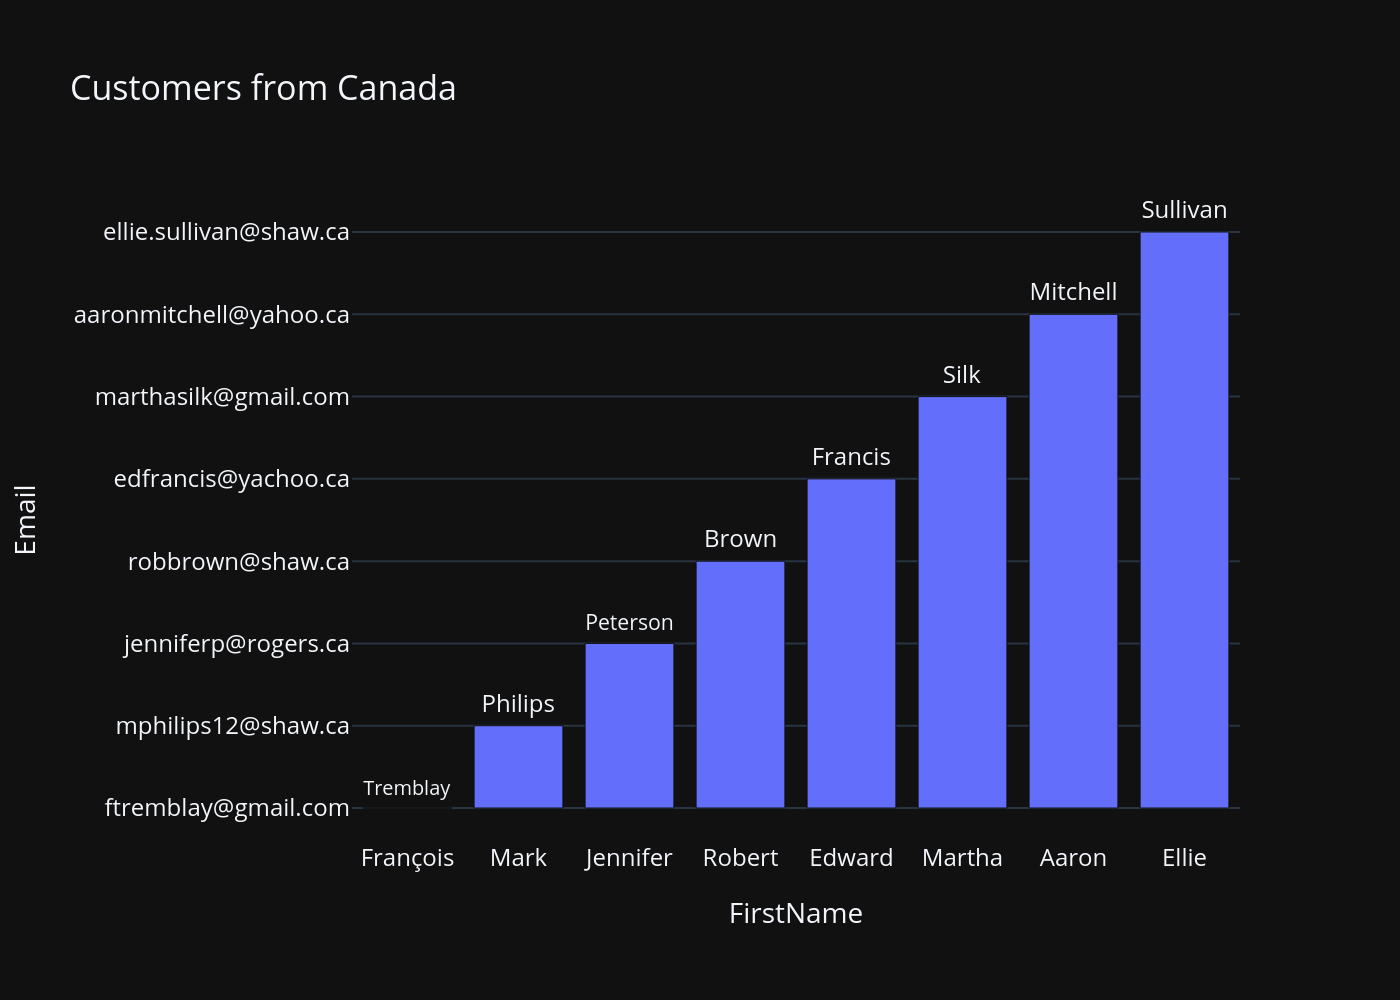





# QUESTION  - 20:  Find the customer with the most invoices 



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer with the most invoices  with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Find the customer with the most invoices  with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 

SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS TotalAlbumQuantity
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbumQuantity DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,TotalAlbumQuantity
0,1,Luís,Gonçalves,38
1,2,Leonie,Köhler,38
2,3,François,Tremblay,38
3,4,Bjørn,Hansen,38
4,5,František,Wichterlová,38



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df) == 1:
    fig = px.indicator(value=df['TotalAlbumQuantity'].iloc[0], title="Top Customers' Total Album Quantity")
else:
    fig = px.bar(df, x='FirstName', y='TotalAlbumQuantity', text='TotalAlbumQuantity')
    fig.update_layout(title='Top 5 Customers Who Bought the Most Albums in Total Quantity (across all invoices)')

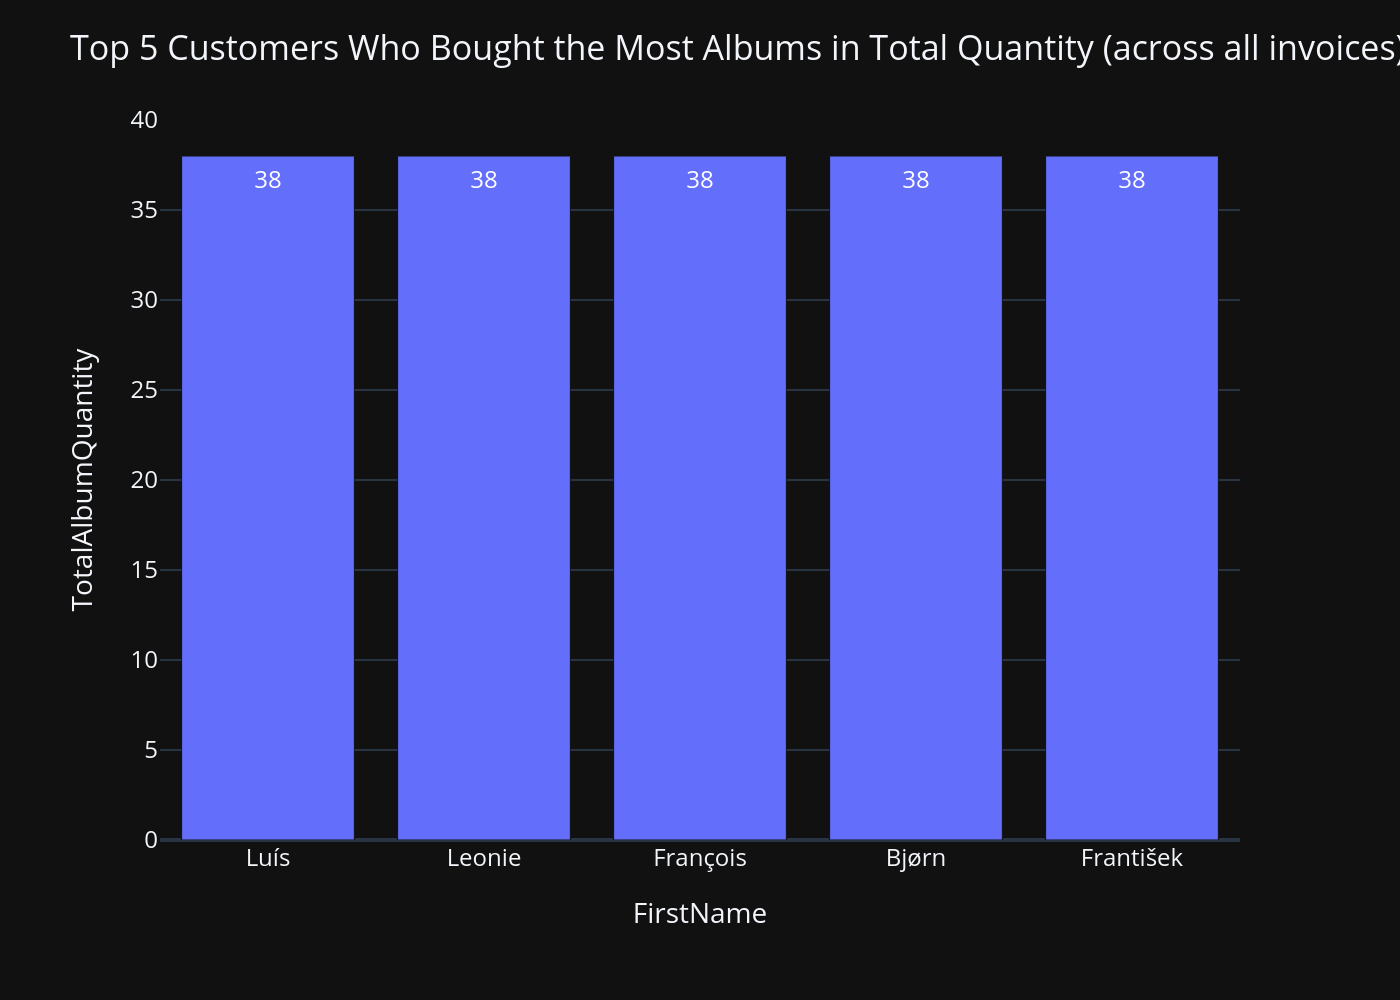





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, SUM(i.Total) AS TotalSpent
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY TotalSpent DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,CustomerName,TotalSpent
0,6,Helena Holý,49.62
1,26,Richard Cunningham,47.62
2,57,Luis Rojas,46.62
3,45,Ladislav Kovács,45.62
4,46,Hugh O'Reilly,45.62



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if len(df) == 1:
    fig = px.indicator(value=df['TotalSpent'].values[0], title="Top Customers Total Spent")
else:
    fig = px.bar(df, x='CustomerName', y='TotalSpent', text='TotalSpent')
    fig.update_layout(title='Top 5 Customers Who Spent the Most Money Overall', xaxis_title='Customer Name', yaxis_title='Total Spent')

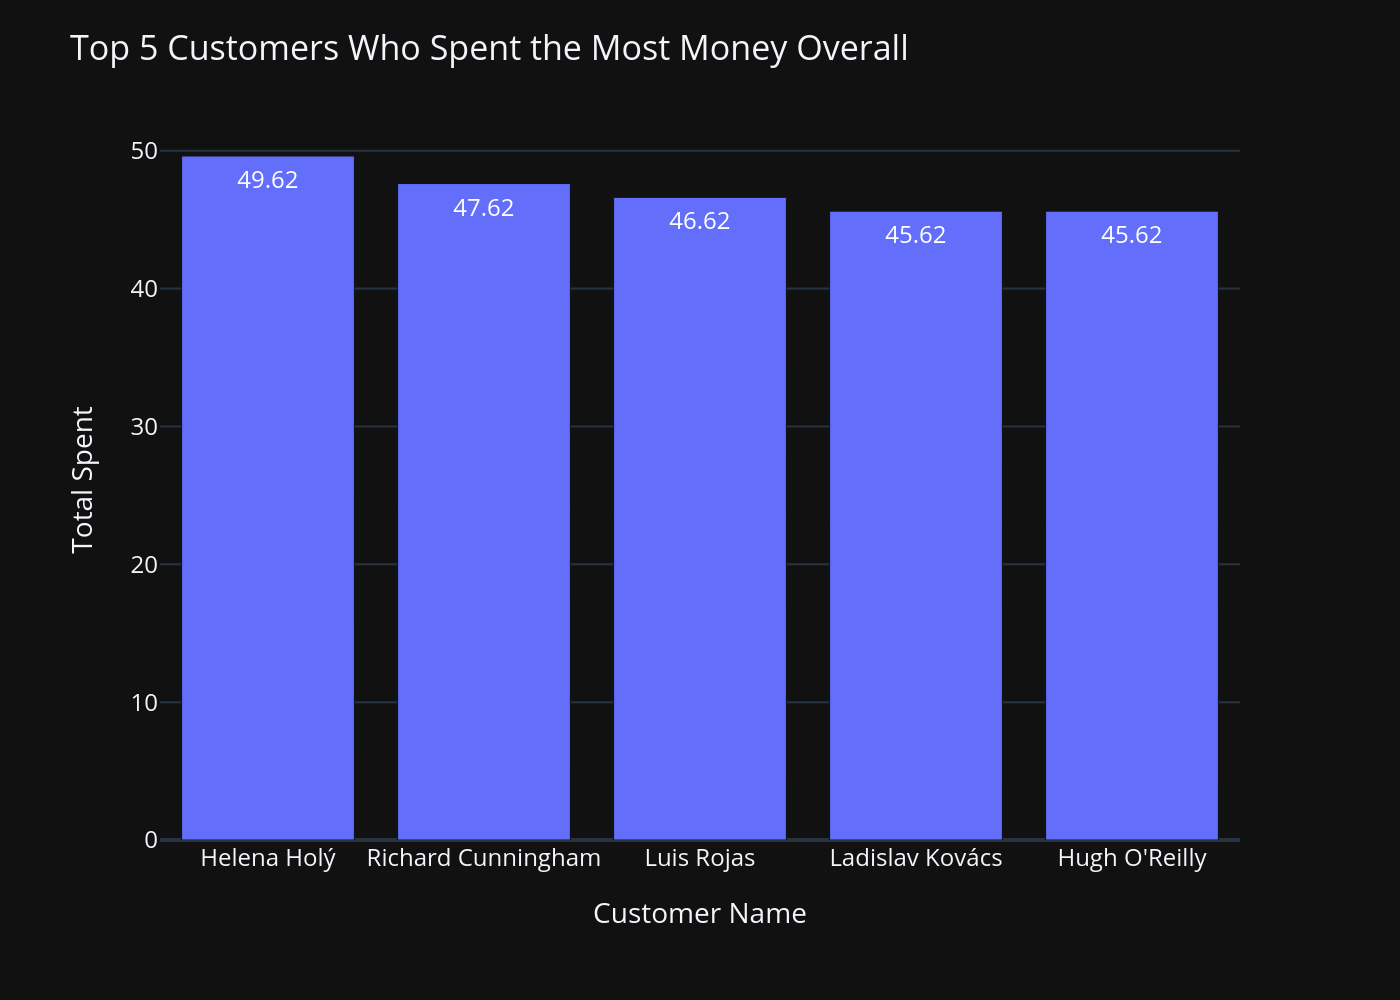





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT p.Name AS PlaylistName, SUM(t.Milliseconds) / 1000 AS TotalDurationSeconds
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId
HAVING COUNT(pt.TrackId) >= 10;


[( <SQL> )]
generated SQL statement



SELECT p.Name AS PlaylistName, SUM(t.Milliseconds) / 1000 AS TotalDurationSeconds
FROM playlists p
JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId
JOIN tracks t ON pt.TrackId = t.TrackId
GROUP BY p.PlaylistId
HAVING COUNT(pt.TrackId) >= 10;


[( <DataFrame> )]
queried dataframe



,PlaylistName,TotalDurationSeconds
0,Music,877683
1,TV Shows,501094
2,90’s Music,398705
3,Music,877683
4,TV Shows,501094
5,Brazilian Music,9486
6,Classical,21770
7,Classical 101 - Deep Cuts,6755
8,Classical 101 - Next Steps,7575
9,Classical 101 - The Basics,7439



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20)  # Limit to first 20 rows if more than 20 rows
if len(df) == 1:
    fig = px.indicator(value=df['TotalDurationSeconds'].iloc[0], title="Total Duration of Tracks in Playlists")
else:
    fig = px.bar(df, x='PlaylistName', y='TotalDurationSeconds', text_auto='.2s')

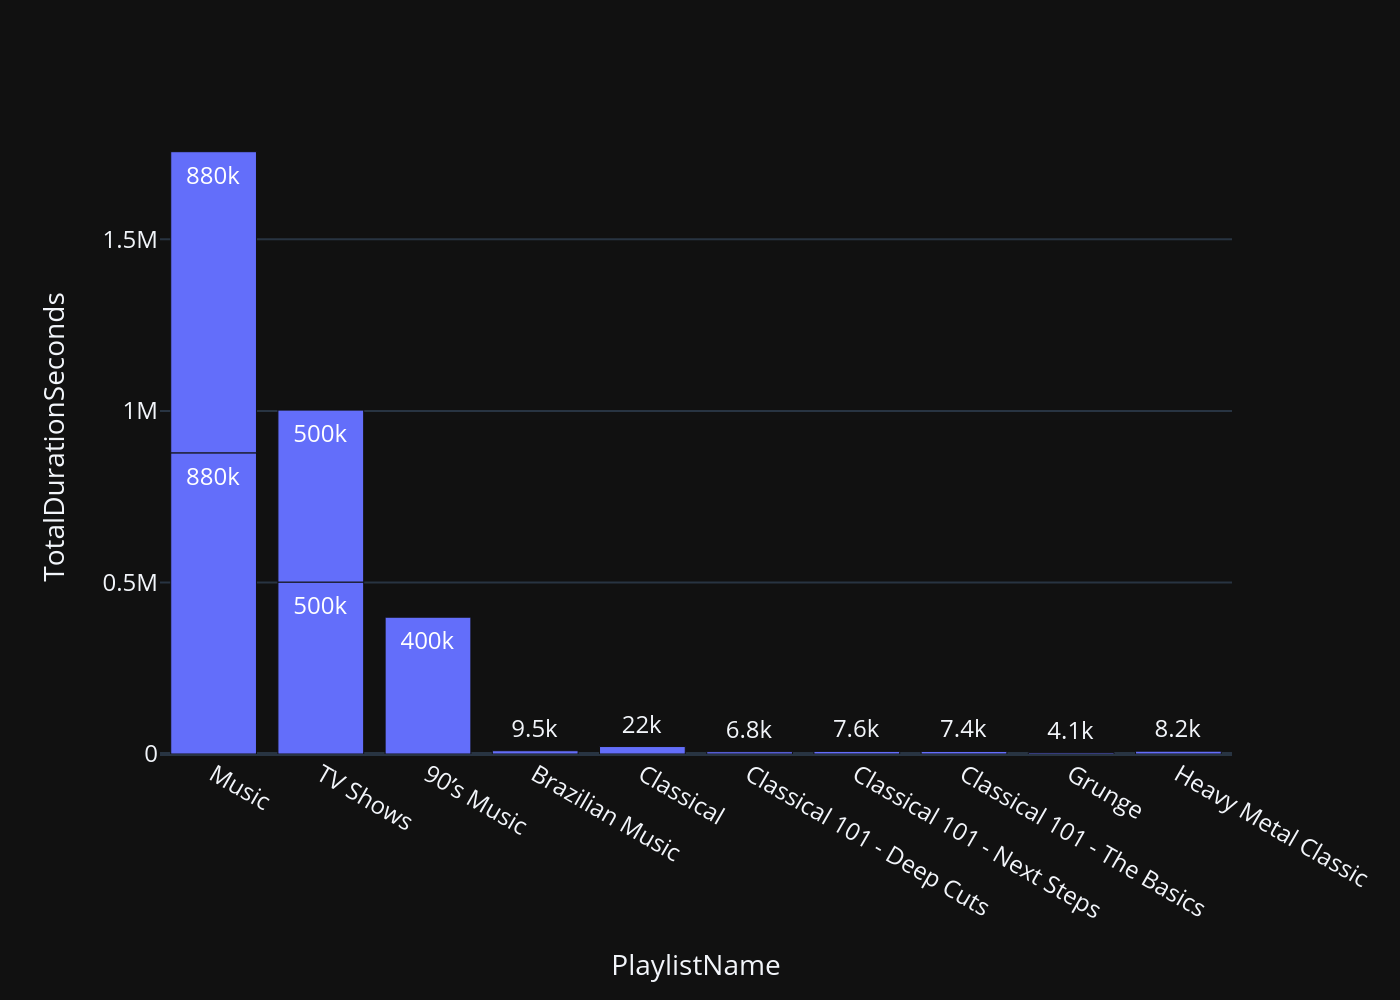





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Identify artists who have albums with tracks appearing in multiple genres: with the following exception: 
an unknown error was encountered while running the model 

Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None

[ERROR-SQL] Failed to generate SQL for prompt: Identify artists who have albums with tracks appearing in multiple genres: with the following exception: 
an unknown error was encountered while running the model 

[( RETRY )]
***** 1

SELECT a.Name AS ArtistName
FROM artists a
JOIN albums al ON a.ArtistId = al.ArtistId
JOIN tracks t ON al.AlbumId = t.AlbumId
JOIN genres g ON t.GenreId = g.GenreId
GROUP BY a.ArtistId
HAVING COUNT(DISTINCT g.GenreId) > 1;


[( <DataFrame> )]
queried dataframe



,ArtistName
0,Antônio Carlos Jobim
1,Audioslave
2,Various Artists
3,Gilberto Gil
4,Eric Clapton
5,Faith No More
6,Foo Fighters
7,Guns N' Roses
8,Iron Maiden
9,Jamiroquai



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

df = df.head(20)  # Assuming you have already limited the data to 20 rows if necessary

if len(df) == 1:
    fig = px.indicator(value=1, title="Indicator for Single Value")
else:
    fig = px.bar(df, x='ArtistName', y=[None], text=['']*len(df), title='Artists with Albums in Multiple Genres')

fig.update_layout(xaxis_title='Artist Name', yaxis_title='Number of Unique Genres')

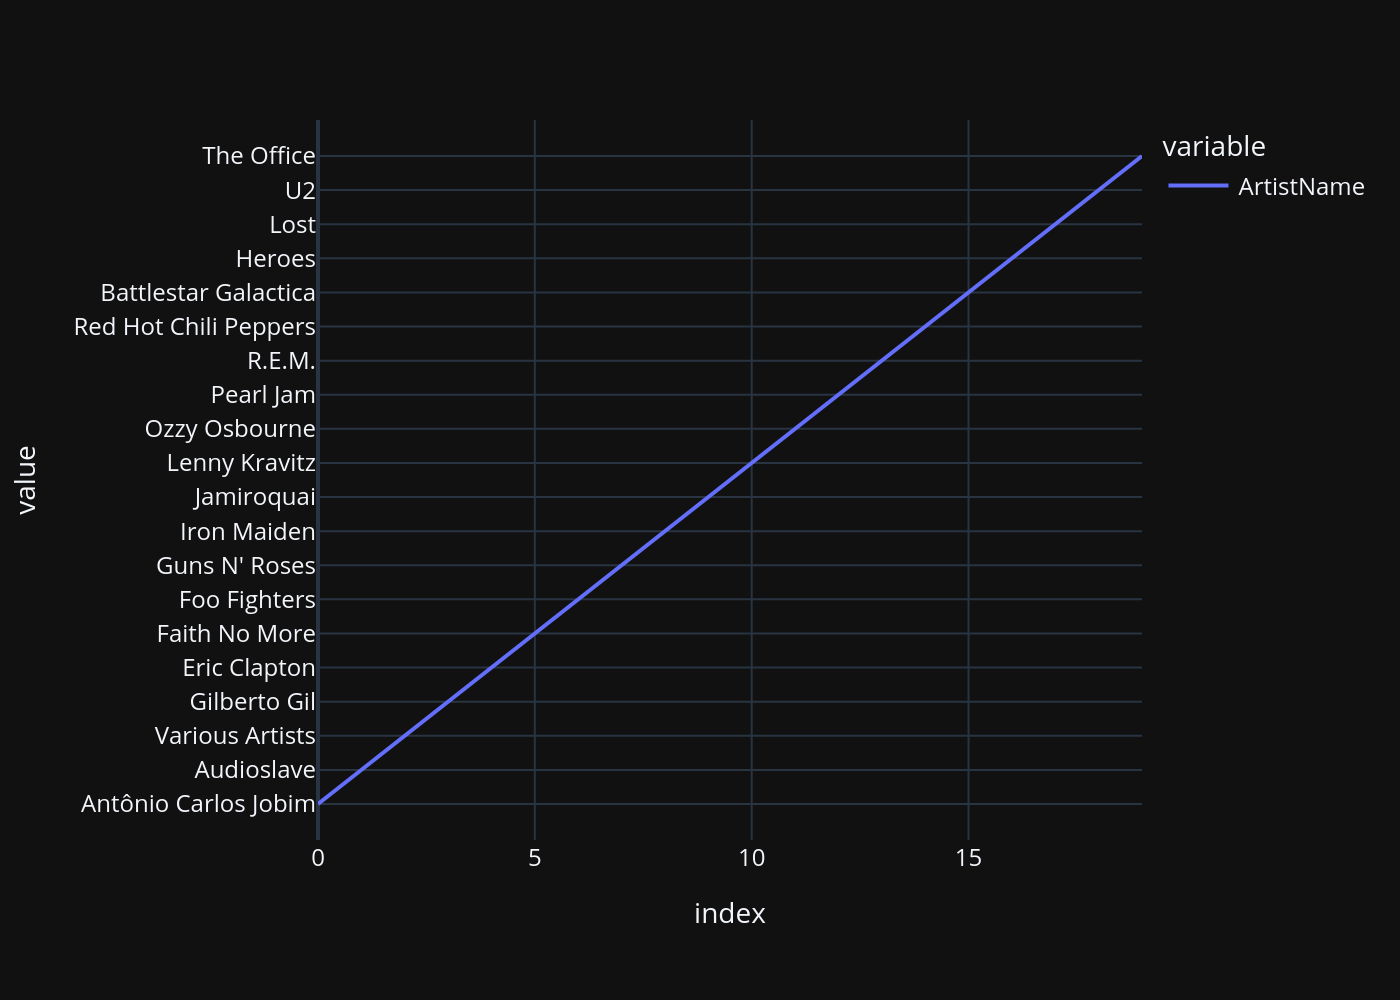

In [15]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [16]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-coder-v2' 
 took 587 sec
 run on 'papa-game' 
 at 20250128-222401


In [17]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv = snake_case(file_csv)

### Save training data

In [18]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,093ce170-6e30-5f22-b6df-9d232c3b1bab-sql,default,\n Generating SQL for this ...,"SELECT InvoiceId, SUM(Total) AS TotalAmountInv...",sql
4,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
5,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
6,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
7,21e0fda8-6d16-57af-9304-d14b98d8ec8a-sql,default,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
8,24618c90-c90e-58d3-97d5-0baaa94d5fae-sql,default,\n Generating SQL for this ...,SELECT a.Name AS ArtistName\nFROM artists a\nJ...,sql
9,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation


In [19]:
df_training_data.to_csv(file_csv, index=False)